In [ ]:
! pip install datasets transformers accelerate evaluate degender-pronoun

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datasets import Dataset
import pandas as pd

#dataset_path = "/Users/benjamyu/workspace/NLP-Letters/data/sentence_sets_trimmed.csv"
dataset_path = "/content/drive/MyDrive/sentence_sets_trimmed.csv"
df = pd.read_csv(dataset_path, encoding='unicode_escape')


In [ ]:
from degender_pronoun import degenderizer

D = degenderizer()

df['s1_s2'] = df['s1_s2'].apply(lambda x: D.degender(x) if len(x) > 5 else x)
#D.degender(df['s1_s2'][0])

In [ ]:
dataset = Dataset.from_pandas(df).rename_column("applicant_gender", "label").class_encode_column("label").train_test_split(test_size=0.2)

Casting to class labels:   0%|          | 0/3285 [00:00<?, ? examples/s]

In [ ]:
df['s1_s2'][0]

"FIRST_NAME LAST_NAME  * LAST_NAME waived his right to review this letter  * LAST_NAME received a clinical score of outstanding   a shelf board score of satisfactory   and an overall core * LAST_NAME received these comments on his core * \x94 attending e FIRST_NAME performed well on the rotation   specific strengths included actively seeking opportunities for patient care   using strong communication strategies to engender trust with patients   asking for continuous feedback and seeking opportunities to educate team   opportunities infections in hiv    *   attending e it was a pleasure working with FIRST_NAME on wards  * FIRST_NAME's a team player   gets along well with other staff and patients and family  * FIRST_NAME helped with team work and was active member of the team  * FIRST_NAME has confidence in himself and enjoys the profession he is about to practice   he has a great attitude   that makes working with him to be fun  * \x94 resident in summary   FIRST_NAME completed internal

In [ ]:
df['s1_s2'][0]

"FIRST_NAME LAST_NAME * LAST_NAME waived their right to review this letter * LAST_NAME received a clinical score of outstanding a shelf board score of satisfactory and an overall core * LAST_NAME received these comments on their core * \x94 attending e FIRST_NAME performed well on the rotation specific strengths included actively seeking opportunities for patient care using strong communication strategies to engender trust with patients asking for continuous feedback and seeking opportunities to educate team opportunities infections in hiv * attending e it was a pleasure working with FIRST_NAME on wards * FIRST_NAME's a team player gets along well with other staff and patients and family * FIRST_NAME helped with team work and was active member of the team * FIRST_NAME has confidence in themselves and enjoys the profession they is about to practice they has a great attitude that makes working with them to be fun * \x94 resident in summary FIRST_NAME completed internal medicine as their 

In [ ]:
df['s1_s2'] = df['s1_s2'].str.replace(' mr ',' ')
df['s1_s2'] = df['s1_s2'].str.replace(' mrs ',' ')
df['s1_s2'] = df['s1_s2'].str.replace(' ms ', '')

In [ ]:
df['s1_s2'][27]

"FIRST_NAME LAST_NAME for their application to anesthesiology * I have recently transitioned out of an 18 year run as anesthesiology program director at LAST_NAME and feel qualified to comment on this excellent applicant * let me start by saying when your last name is the same as the university medical center's student LAST_NAME turns some heads ! * LAST_NAME rotated through our clinical experience with an affability and an ease of learning that did not go unnoticed * LAST_NAME are why we stay in academics ! I write this letter on behalf of * * I worked with them on a few occasions and what stood out was their sincere attitude that learning was a privilege * they seemed to get as much as they gave as they deftly answered my clinical questions and asked clarifying questions of their own * my interactions with them were truly refreshing * I kept thinking that learners like * although I am not privy to their academic record I would imagine they has always demonstrated an affinity for know

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate
from datasets import load_metric
from torch import nn
import torch
#metric = load_metric('glue', 'mrpc')
metric = evaluate.load('f1')

model_checkpoint = "distilbert-base-uncased"
batch_size = 16
task = "nlp-letters-s1-s2-degendered-class-weighted"
metric_name = "f1"
data_column = "s1_s2"
model_name = model_checkpoint.split("/")[-1]
num_labels = 2

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 2 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([8.0, 1.0], device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=True,
)

def preprocess_function(sample):
    return tokenizer(sample[data_column], truncation=True, padding=True)

accuracy = load_metric("accuracy")
precision = load_metric("precision")
recall = load_metric("recall")
f1 = load_metric("f1")


confusion_metric = evaluate.load("confusion_matrix")

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return confusion_metric.compute(predictions=predictions, references=labels)

def compute_metrics(eval_pred):
    x, y = eval_pred
    preds = np.argmax(x, -1)
    print(confusion_metric.compute(predictions=preds, references=y))
    return metric.compute(predictions=preds, references=y, average="macro")

encoded_dataset = dataset.map(preprocess_function, batched=True)

# trainer = Trainer(
#     model,
#     args,
#     train_dataset=encoded_dataset["train"],
#     eval_dataset=encoded_dataset["test"],
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics
# )


trainer = CustomTrainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/2628 [00:00<?, ? examples/s]

Map:   0%|          | 0/657 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.548368,0.226148
2,No log,0.344044,0.783398
3,No log,0.378608,0.509214
4,0.457100,0.420959,0.754831
5,0.457100,0.519507,0.753287
6,0.457100,0.809588,0.823758
7,0.213900,1.033636,0.817606
8,0.213900,1.015335,0.794203
9,0.213900,1.103262,0.796405
10,0.059000,1.174011,0.803781


{'confusion_matrix': array([[192,   0],
       [465,   0]])}
{'confusion_matrix': array([[146,  46],
       [ 77, 388]])}
{'confusion_matrix': array([[190,   2],
       [319, 146]])}
{'confusion_matrix': array([[155,  37],
       [109, 356]])}
{'confusion_matrix': array([[152,  40],
       [106, 359]])}
{'confusion_matrix': array([[131,  61],
       [ 30, 435]])}
{'confusion_matrix': array([[134,  58],
       [ 38, 427]])}
{'confusion_matrix': array([[144,  48],
       [ 67, 398]])}
{'confusion_matrix': array([[140,  52],
       [ 60, 405]])}
{'confusion_matrix': array([[137,  55],
       [ 51, 414]])}


TrainOutput(global_step=1650, training_loss=0.22293965469707142, metrics={'train_runtime': 800.84, 'train_samples_per_second': 32.816, 'train_steps_per_second': 2.06, 'total_flos': 3481243236679680.0, 'train_loss': 0.22293965469707142, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

{'confusion_matrix': array([[131,  61],
       [ 30, 435]])}


{'eval_loss': 0.8095878958702087,
 'eval_f1': 0.8237583018161558,
 'eval_runtime': 6.3411,
 'eval_samples_per_second': 103.609,
 'eval_steps_per_second': 6.623,
 'epoch': 10.0}

In [ ]:
trainer.push_to_hub()

events.out.tfevents.1719385288.b72d828852fc.3039.8:   0%|          | 0.00/405 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ben-yu/distilbert-base-uncased-finetuned-nlp-letters-s1-s2-degendered-class-weighted/commit/3b89f270074f2c87e779bdc708a322fd607deabb', commit_message='End of training', commit_description='', oid='3b89f270074f2c87e779bdc708a322fd607deabb', pr_url=None, pr_revision=None, pr_num=None)

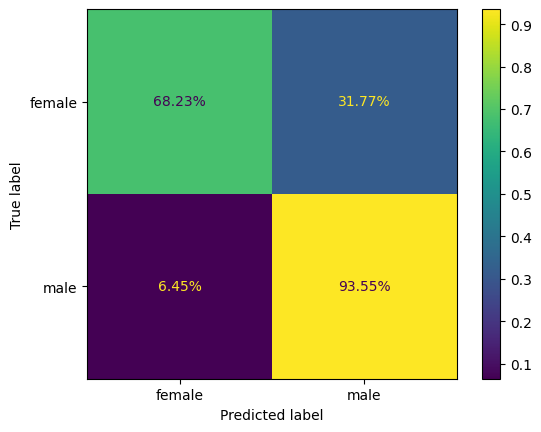

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = np.array([[131,  61],
       [ 30, 435]])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['female','male'])
disp.plot(values_format='.2%')
#disp.plot()


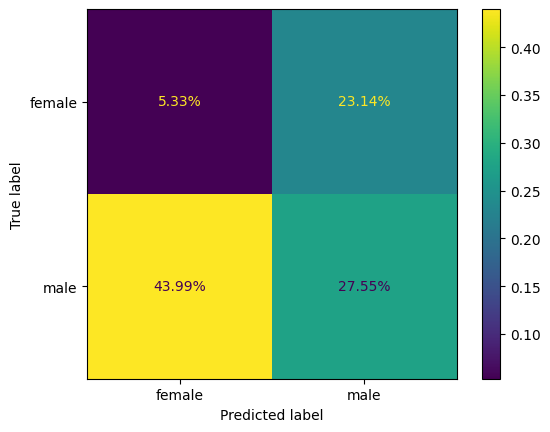

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=np.array([[ 35.0/657.0, 152.0/657.0], [289.0/657.0, 181.0/657.0]]),
                              display_labels=['female','male'])
disp.plot(values_format='.2%')

In [ ]:
dataset['train'].features

{'applicant_id': Value(dtype='string', id=None),
 'document': Value(dtype='string', id=None),
 'writer_gender': Value(dtype='string', id=None),
 'letter_type': Value(dtype='string', id=None),
 'label': ClassLabel(names=['female', 'male'], id=None),
 'applicant_identify': Value(dtype='string', id=None),
 'applicant_identify_group': Value(dtype='string', id=None),
 'standardized_lor': Value(dtype='int64', id=None),
 'us_canadian': Value(dtype='int64', id=None),
 'usmle_1': Value(dtype='int64', id=None),
 'usmle_2': Value(dtype='int64', id=None),
 'applicants_writers': Value(dtype='string', id=None),
 'TEXT': Value(dtype='string', id=None),
 'full_text': Value(dtype='string', id=None),
 's1': Value(dtype='string', id=None),
 's2': Value(dtype='string', id=None),
 's1_s2': Value(dtype='string', id=None),
 's3': Value(dtype='string', id=None),
 'full_text_tokens': Value(dtype='int64', id=None)}

In [ ]:
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107720 sha256=224ac947d6621b0cec07376d0597edd479e79ac321418a96d357bc66c33c3e9c
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
!pip install scipy

In [ ]:
import scipy
import numpy as np
def monkeypath_itemfreq(sampler_indices):
   return zip(*np.unique(sampler_indices, return_counts=True))

scipy.stats.itemfreq=monkeypath_itemfreq

import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from eli5.lime import TextExplainer




model_checkpoint = "ben-yu/distilbert-base-uncased-finetuned-nlp-letters-s1-s2-degendered"
batch_size = 16
task = "nlp-letters"
metric_name = "accuracy"
data_column = "full_text"
model_name = model_checkpoint.split("/")[-1]
num_labels = 2

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels, low_cpu_mem_usage=True)
def model_adapter(texts):

    all_scores = []
    for i in range(0, len(texts), 64):
        batch = texts[i:i+64]

        # use bert encoder to tokenize text
        encoded_input = tokenizer(batch,
          return_tensors='pt',
          padding=True,
          truncation=True,
          max_length=model.config.max_position_embeddings-2)
        # run the model
        output = model(**encoded_input)
        # by default this model gives raw logits rather
        # than a nice smooth softmax so we apply it ourselves here
        scores = output[0].softmax(1).detach().numpy()
        all_scores.extend(scores)
    return np.array(all_scores)


class_names = ['female', 'male']
text = """
I am pleased to provide my unqualified support for FIRST_NAME LAST_NAME  FIRST_NAME strikes me as someone who  will achieve at a high level in a residency program  she is mature   has other non   medical experiences   teach for america     and has a demonstrated record of superior achievement  her board scores are competitive and she has numerous honors in our major clinical rotations  I have spent time in conversation with her regarding anesthesiology and I have worked with her in the operating room  in the operating room   I was particularly struck by her aptitude and quiet confidence  I hope you ask her about her experiences while a teacher  I find these supplemental life experiences additive to any program  I know that we will make every effort to recruit her to unc
"""

te = TextExplainer(n_samples=5000, random_state=42, position_dependent=True)
te.fit(D.degender(text), model_adapter)
te.explain_prediction(target_names=class_names)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Explanation(estimator="SGDClassifier(alpha=0.001, loss='log', penalty='elasticnet',\n              random_state=RandomState(MT19937) at 0x788A0E328D40)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='male', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='[102] experiences', weight=1.530778304168425, std=None, value=1.0), FeatureWeight(feature='<BIAS>', weight=0.7182951095265415, std=None, value=1.0), FeatureWeight(feature='[91] aptitude', weight=0.5576194059603512, std=None, value=1.0), FeatureWeight(feature='[94] confidence', weight=0.36479520871030097, std=None, value=1.0), FeatureWeight(feature='[105] teacher', weight=0.30907863487491716, std=None, value=1.0), FeatureWeight(feature='[99] them', weight=0.3079141951282917, std=None, value=1.0), FeatureWeight(feature='[68] them', weight=0.3067636927494124, std=None, value=1.0), FeatureWeight(feature='[76] them', weight=0.3008217273648056, std=None, value=1.0), FeatureWeight(feature='[126] them', weight=0.24144782614566576, std=None, value=1.0), FeatureWeight(feature='[47] board', weight=0.16562015038581648, std=None, value=1.0), FeatureWeight(feature='[93] quiet', weight=0.15240310833262283, std=None, value=1.0), FeatureWeight(feature='[44] superior', weight=0.13613379112133336, std=None, value=1.0), FeatureWeight(feature='[48] scores', weight=0.12410024773758638, std=None, value=1.0), FeatureWeight(feature='[32] non', weight=0.1192311957994065, std=None, value=1.0), FeatureWeight(feature='[6] unqualified', weight=0.10338309313855015, std=None, value=1.0), FeatureWeight(feature='[18] achieve', weight=0.10146005103669935, std=None, value=1.0), FeatureWeight(feature='[3] to', weight=0.09923853001662065, std=None, value=1.0), FeatureWeight(feature='[74] worked', weight=0.09675935337501386, std=None, value=1.0), FeatureWeight(feature='[10] LAST_NAME', weight=0.07846351469478571, std=None, value=1.0), FeatureWeight(feature='[50] competitive', weight=0.07777097045107169, std=None, value=1.0), FeatureWeight(feature='[96] hope', weight=0.07763236708660394, std=None, value=1.0), FeatureWeight(feature='[23] in', weight=0.07514926364330439, std=None, value=1.0), FeatureWeight(feature='[85] I', weight=0.07483320957424275, std=None, value=1.0), FeatureWeight(feature='[67] with', weight=0.06266048676212424, std=None, value=1.0), FeatureWeight(feature='[27] they', weight=0.057587101617516026, std=None, value=1.0), FeatureWeight(feature='[118] that', weight=0.0560240139139093, std=None, value=1.0), FeatureWeight(feature='[5] my', weight=0.05491082401029797, std=None, value=1.0), FeatureWeight(feature='[63] spent', weight=0.05102521587575609, std=None, value=1.0), FeatureWeight(feature='[56] in', weight=0.047958262093157976, std=None, value=1.0), FeatureWeight(feature='[109] supplemental', weight=0.045091194700456076, std=None, value=1.0), FeatureWeight(feature='[51] and', weight=0.04471744283872262, std=None, value=1.0), FeatureWeight(feature='[123] effort', weight=0.04118150211196058, std=None, value=1.0), FeatureWeight(feature='[24] a', weight=0.04106799285591208, std=None, value=1.0), FeatureWeight(feature='[66] conversation', weight=0.039551731827938585, std=None, value=1.0), FeatureWeight(feature='[114] any', weight=0.039371506879755803, std=None, value=1.0), FeatureWeight(feature='[35] teach', weight=0.033669514288722564, std=None, value=1.0), FeatureWeight(feature='[115] program', weight=0.025975554893814663, std=None, value=1.0), FeatureWeight(feature='[40] a', weight=0.02318621557322104, std=None, value=1.0), FeatureWeight(feature='[121] make', weight=0.02157763489145755, std=None, value=1.0), FeatureWeight(feature='[120] will', weight=0.020347869204141902, std=None, value=1.0), FeatureWeight(feature='[22] level', weight=0.01608106179327378, std=None, value=1.0), FeatureWeight(feature='[116] I', weight=0.00942199408800239, std=None, value=1.0), FeatureWeight(feature='[82] the', weight=0.007271563603004553, std=

In [ ]:
te.explain_weights(target_names=class_names)

Weight?,Feature
+1.531,[102] experiences
+0.718,<BIAS>
+0.558,[91] aptitude
+0.365,[94] confidence
+0.309,[105] teacher
+0.308,[99] them
+0.307,[68] them
+0.301,[76] them
+0.241,[126] them
+0.166,[47] board


In [ ]:
class_names = ['female', 'male']
text = """
this letter serves as the department of medicine letter for FIRST_NAME LAST_NAME  these letters are written and compiled by the clerkship director and associate clerkship director with help from our clerkship coordinator  they are written in accordance with the cdim   apdim guidelines for department of medicine letters  LAST_NAME waived his right to review this letter  the core internal medicine clerkship at unm is 8   weeks in duration and consists of 6 weeks spent in the inpatient setting at our university and veteran's affairs hospitals as well as 2 weeks split on palliative care and ambulatory medicine  students final grade is on the ogsf scale   outstanding   good   satisfactory   fail   with 50 % of the grade based on clinical performance   25 % on shelf board   15 % on quizzes   consisting of students writing a problem list   assessment statement and differential diagnosis based on a paper case     and 10 % on professionalism  LAST_NAME received a clinical score of outstanding   a shelf board score of satisfactory   and an overall core im clerkship score of good  LAST_NAME received these comments on his core im clerkship    great documentation with accurate and well thought out assessments  active in requesting new tasks to help team and patient care  î attending e FIRST_NAME performed well on the rotation   specific strengths included actively seeking opportunities for patient care   using strong communication strategies to engender trust with patients   asking for continuous feedback and seeking opportunities to educate team   opportunities infections in hiv      attending e it was a pleasure working with FIRST_NAME on wards  FIRST_NAME's a team player   gets along well with other staff and patients and family  FIRST_NAME helped with team work and was active member of the team  his presentations were detailed oriented   write ups were well organized and thoughtful  he took extra initiative in educating the team about various topics including atrial fibrillation management   relevance of mrsa nares   sleep medications and medication interactions  he stayed late on several occasions to finish his work and help the team  he commits to patient care and delivers  î   attending  great patient care   prioritizes tasks   gathers all pertinent information from patients  outstanding knowledge   great clinical correlation   identifies new problems independently  great patient ownership   even followed important aspects of patients that he saw before but not seeing that day  really great bedside manner  spontaneously researches on patients cases and educates the team with what he learns  FIRST_NAME has confidence in himself and enjoys the profession he is about to practice   he has a great attitude   that makes working with him to be fun  I personally learned from his great positive attitude and disposition  professional with patients and team  î resident e sees a lot of patients   takes initiative to see new patients   good communication skills with patients   works well with residents   open to feedback  î resident in summary   FIRST_NAME completed internal medicine as his first clerkship in his phase il experience and performed very well clinically  he showed a strong work ethic during his clerkship within internal medicine   being noted by both unmh and va attendings to be an active member of the team and stay late when needed  he will FIRST_NAME a strong resident physician """

te = TextExplainer(n_samples=5000, random_state=42, position_dependent=True)
te.fit(D.degender(text), model_adapter)
te.explain_prediction(target_names=class_names)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Explanation(estimator="SGDClassifier(alpha=0.001, loss='log', penalty='elasticnet',\n              random_state=RandomState(MT19937) at 0x788A10C7ED40)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='female', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='[305] mrsa', weight=0.8340101452390452, std=None, value=1.0), FeatureWeight(feature='[414] to', weight=0.7248493525849338, std=None, value=1.0), FeatureWeight(feature='[306] nares', weight=0.3482979646264852, std=None, value=1.0), FeatureWeight(feature='[324] the', weight=0.3002504274449922, std=None, value=1.0), FeatureWeight(feature='[421] their', weight=0.26166565825912635, std=None, value=1.0), FeatureWeight(feature='[45] medicine', weight=0.2264725582101421, std=None, value=1.0), FeatureWeight(feature='[467] their', weight=0.21848489354821227, std=None, value=1.0), FeatureWeight(feature='[322] and', weight=0.1977552317796821, std=None, value=1.0), FeatureWeight(feature='[33] are', weight=0.19642071137898628, std=None, value=1.0), FeatureWeight(feature='[384] the', weight=0.193416664984898, std=None, value=1.0), FeatureWeight(feature='[236] in', weight=0.17697112486187963, std=None, value=1.0), FeatureWeight(feature='[302] management', weight=0.17290311585037632, std=None, value=1.0), FeatureWeight(feature='[482] a', weight=0.1701913855565919, std=None, value=1.0), FeatureWeight(feature='[386] with', weight=0.15692635303995917, std=None, value=1.0), FeatureWeight(feature='[276] their', weight=0.15593421636415308, std=None, value=1.0), FeatureWeight(feature='[433] resident', weight=0.14784042076621245, std=None, value=1.0), FeatureWeight(feature='[257] with', weight=0.14632250559739227, std=None, value=1.0), FeatureWeight(feature='[244] working', weight=0.14572495321160417, std=None, value=1.0), FeatureWeight(feature='[328] to', weight=0.13843778431913675, std=None, value=1.0), FeatureWeight(feature='[188] requesting', weight=0.13840276095507253, std=None, value=1.0), FeatureWeight(feature='[265] helped', weight=0.13737746109434162, std=None, value=1.0), FeatureWeight(feature='[78] our', weight=0.13713975752737387, std=None, value=1.0), FeatureWeight(feature='[230] opportunities', weight=0.13555667354369513, std=None, value=1.0), FeatureWeight(feature='[101] on', weight=0.13527022066195607, std=None, value=1.0), FeatureWeight(feature='[148] a', weight=0.13465043442047928, std=None, value=1.0), FeatureWeight(feature='[383] educates', weight=0.1346408348568013, std=None, value=1.0), FeatureWeight(feature='[471] their', weight=0.12164493395089185, std=None, value=1.0), FeatureWeight(feature='[323] help', weight=0.12152428619546943, std=None, value=1.0), FeatureWeight(feature='[247] on', weight=0.11851272489019309, std=None, value=1.0), FeatureWeight(feature='[57] internal', weight=0.11449358982430467, std=None, value=1.0), FeatureWeight(feature='[266] with', weight=0.11376333436915957, std=None, value=1.0), FeatureWeight(feature='[422] great', weight=0.11227032407897125, std=None, value=1.0), FeatureWeight(feature='[333] î', weight=0.11218414388731181, std=None, value=1.0), FeatureWeight(feature='[183] thought', weight=0.11192244428796441, std=None, value=1.0), FeatureWeight(feature='[283] were', weight=0.11111244381783822, std=None, value=1.0), FeatureWeight(feature='[116] clinical', weight=0.109852230137108, std=None, value=1.0), FeatureWeight(feature='[134] and', weight=0.10721157893684381, std=None, value=1.0), FeatureWeight(feature='[497] and', weight=0.1072044161512684, std=None, value=1.0), FeatureWeight(feature='[477] very', weight=0.10527856208840461, std=None, value=1.0), FeatureWeight(feature='[240] it', weight=0.10499223378426356, std=None, value=1.0), FeatureWeight(feature='[377] spontaneously', weight=0.10291399759165848, std=None, value=1.0), FeatureWeight(feature='[393] in', weight=0.10222449521910287, std=None, value=1.0), FeatureWeight(feature='[51] to', weight=0.10141110062280431, st

In [ ]:
te.explain_weights(target_names=class_names)

Weight?,Feature
+1.653,<BIAS>
+0.450,[413] them
+0.322,[385] team
+0.281,[301] fibrillation
+0.276,[469] clerkship
+0.248,[424] attitude
+0.245,[474] experience
+0.239,[325] team
+0.212,[237] hiv
+0.189,[321] work
